# Using R packages for DID estimators in Python

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import IntVector, Formula
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind = 1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000023D3F108DC0> [RTYPES.NILSXP]

### Import R packages

In [2]:
%%capture

# Bacon Decomposition
utils.install_packages("bacondecomp")
bacondecomp = rpackages.importr('bacondecomp')

# Brantly Callaway, Pedro H.C. Sant’Anna (2020) estimator
utils.install_packages("did")
did = rpackages.importr('did')

# Clément de Chaisemartin, Xavier D’Haultfoeuille (2020)
utils.install_packages("DIDmultiplegt")
DIDmultiplegt = rpackages.importr('DIDmultiplegt')

# Pedro H.C. Sant’Anna , Jun Zhao (2020).
utils.install_packages("DRDID")
DRDID = rpackages.importr('DRDID')

# Liyang Sun, Sarah Abraham (2020)
utils.install_packages("fixest")
fixest = rpackages.importr('fixest')

# Kirill Borusyak, Xavier Jaravel, Jann Spiess (2021)
utils.install_packages("didimputation")
didimputation = rpackages.importr('didimputation')

# Gardner (2021)
utils.install_packages("did2s")
did2s = rpackages.importr('did2s')

# Broom package for working with fixest models
utils.install_packages("broom")
broom = rpackages.importr('broom')

### Example using Castle dataset

In [7]:
# Import data
data = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/castle.dta")

# Set groups that are never-treated to have a value of 0 
# This is easier for conversion to an R/rpy2 DataFrame
data.effyear[data.effyear.isnull()] = 0

# Convert the pandas df to an R/rpy2 DataFrame for use with the R packages
with localconverter(ro.default_converter + pandas2ri.converter):
      rdata = ro.conversion.py2rpy(data)

C:\Users\sajidmu2\AppData\Local\Temp\ipykernel_16664\864293413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.effyear[data.effyear.isnull()] = 0


In [8]:
# Use the did2s R package to estimate TWFE, 
# Gardner (2021), 
# Callaway and Sant'Anna (2020),
# Sun and Abraham (2020)
# Borusyak, Jaravel, Spiess (2021)
# Roth and Sant'Anna (2021)

modelsr = did2s.event_study(data = rdata,
                 yname = 'l_homicide',
                 gname = 'effyear',
                 idname = 'sid',
                 tname = 'year')

Estimating TWFE Model
Estimating using Gardner (2021)
Estimating using Callaway and Sant'Anna (2020)
Estimating using Sun and Abraham (2020)
Estimating using Borusyak, Jaravel, Spiess (2021)
Estimatng using Roth and Sant'Anna (2021)


R[write to console]: Error in create_Atheta_list_for_event_study(eventTime = eventTime, g_list = g_list,  : 
  There are no comparison cohorts for the given eventTime

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 2005,2007,2008,2009.

R[write to console]: 2: 
R[write to console]: In did::att_gt(yname = yname, tname = tname, idname = idname, gname = gname,  :
R[write to console]: 
 
R[write to console]:  Not returning pre-test Wald statistic due to singular covariance matrix

R[write to console]: 3: 
R[write to console]: In staggered::staggered(data_staggered, i = idname, t = tname, g = gname,  :
R[write to console]: 
 
R[write to console]:  The treatment cohorts g = 2005, 2009 have a single cross-sectional unit only. We drop

In [9]:
# Convert table containing estimates to a pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
      models = ro.conversion.rpy2py(modelsr)

In [10]:
# Check the estimators in the df
pd.unique(models.estimator)
# Get the available ones
twfe = models[models.estimator == "TWFE"]
csant = models[models.estimator == "Callaway and Sant'Anna (2020)"]
sunab = models[models.estimator == "Sun and Abraham (2020)"]
imput = models[models.estimator == "Borusyak, Jaravel, Spiess (2021)"]

Text(0.5, 0.98, 'DID Estimators - Castle data, Cheng and Hoekstra (2013)')

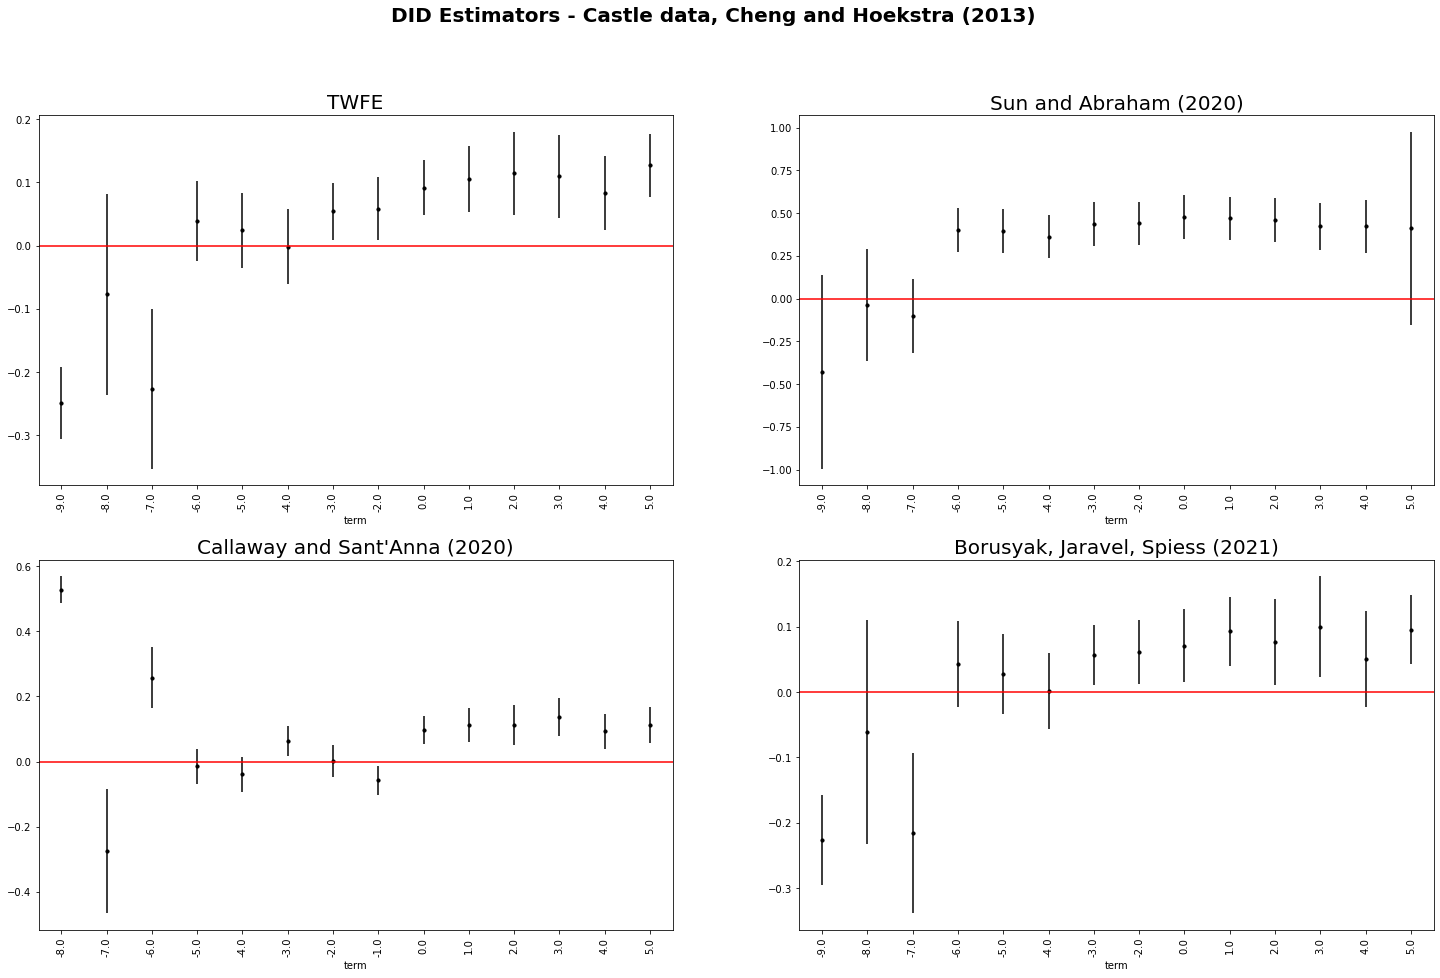

In [14]:
# Create a plot for the estimators that are suitable for our data/model

fig = plt.figure(figsize = (25, 15))

ax1 = fig.add_subplot(2, 2, 1)
twfe.plot(x = 'term', y = 'estimate', kind = 'bar', 
             ax = ax1, color = 'none', 
             yerr ='std.error', legend = False)
ax1.axhline(y = 0, color='r', linestyle='-')
ax1.scatter(x = np.arange(twfe.shape[0]), 
           marker = 'o', s = 10, 
           y = twfe['estimate'], color = 'black')
ax1.set_title('TWFE', size = 20)

ax2 = fig.add_subplot(2, 2, 2)
sunab.plot(x = 'term', y = 'estimate', kind = 'bar', 
             ax = ax2, color = 'none', 
             yerr ='std.error', legend = False)
ax2.axhline(y = 0, color='r', linestyle='-')
ax2.scatter(x = np.arange(sunab.shape[0]), 
           marker = 'o', s = 10, 
           y = sunab['estimate'], color = 'black')
ax2.set_title('Sun and Abraham (2020)', size = 20)

ax3 = fig.add_subplot(2, 2, 3)
csant.plot(x = 'term', y = 'estimate', kind = 'bar', 
             ax = ax3, color = 'none', 
             yerr ='std.error', legend = False)
ax3.axhline(y = 0, color='r', linestyle='-')
ax3.scatter(x = np.arange(csant.shape[0]), 
           marker = 'o', s = 10, 
           y = csant['estimate'], color = 'black')
ax3.set_title("Callaway and Sant'Anna (2020)", size = 20)

ax4 = fig.add_subplot(2, 2, 4)
imput.plot(x = 'term', y = 'estimate', kind = 'bar', 
             ax = ax4, color = 'none', 
             yerr ='std.error', legend = False)
ax4.axhline(y = 0, color='r', linestyle='-')
ax4.scatter(x = np.arange(imput.shape[0]), 
           marker = 'o', s = 10, 
           y = imput['estimate'], color = 'black')
ax4.set_title('Borusyak, Jaravel, Spiess (2021)', size = 20)

fig.suptitle("DID Estimators - Castle data, Cheng and Hoekstra (2013)", fontweight = 'bold', size = 20)

## Sample code for using the R packages in Python

The following sub-sections gives sample code you can adapt to estimate models using the packages listed above.

### Callaway and Sant'Anna (2020) - did package

In [ ]:
# Estimate model, using the data converted to an R/rpy2 DataFrame

get_att_gt = did.att_gt(data = rdataframe,
          yname = 'outcome',
          tname = 'year',
          idname = 'id',
          gname = 'group', 
          control_group = 'notyettreated')

# Aggregate results and extract for converting to a Pandas df
# You can toggle the aggregation type for whatever you want
csdid_results_r = did.tidy_AGGTEobj(did.aggte(get_att_gt, type = "dynamic"))

# The results table is an R/rpy2 dataframe. Convert this to a Pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
    csdid_results = ro.conversion.rpy2py(csdid_results_r)

# Print table
csdid_results

### Sun and Abraham (2020 )- uses sunab in the fixest R package

In [ ]:
# Estimate model, using your dataset converted to an R/rpy2 DataFrame

sunab_mod = fixest.feols(fml = Formula("outcome ~ sunab(treat_date, year) | id + year"), 
             data = rdataframe)

# Get results table 
sunab_resultsr = broom.tidy_fixest(sunab_mod)

# The results table is an R/rpy2 dataframe. Convert this to a Pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
    sunab_results = ro.conversion.rpy2py(sunab_resultsr)

# Print table
sunab_results

### Chaisemartin and D’Haultfoeuille (2020) - uses the DIDmultiplegt R package

In [ ]:
# The function automatically plots an event-study if you're specifying the dynamic and placebo options.
# This isn't great for our purposes so turning that off for now.
# Load R graphics devices package
grdevices = importr('grDevices')

# Turn graphics device off
grdevices.dev_off()

# Estimate model, using your dataset converted to an R/rpy2 DataFrame
chaise_mod = DIDmultiplegt.did_multiplegt(df = rdataframe,
                            Y = 'outcome',
                            G = 'group',
                            T = 'year',
                            D = 'treat', 
                            dynamic = 20, placebo = 20)

# You have to do some work to get the results in a neat table because they're stored as a list.
chaise_mod = base.do_call("rbind", chaise_mod)
chaise_mod = base.as_data_frame(chaise_mod)

# The results table is an R/rpy2 dataframe. Convert this to a Pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
    chaise_results = ro.conversion.rpy2py(chaise_mod)
    
# Print table 
# Note: you'll probably have to do some further manipulation with this depending on what you're interested in
chaise_results

### Borusyak, Jaravel, Spiess (2021) - uses the didimputation R package

In [ ]:
# Estimate model, using your dataset converted to an R/rpy2 DataFrame
imputation_resultsr = didimputation.did_imputation(data = rdataframe,
                            yname = 'outcome',
                            gname = 'group',
                            tname = 'year',
                            idname = 'id', 
                            horizon = True, pretrends = True)

# The results table is an R/rpy2 dataframe. Convert this to a Pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
    imputation_results = ro.conversion.rpy2py(imputation_resultsr)
    
# Print table
imputation_results